<a href="https://colab.research.google.com/github/joshuaghannan/ECEC247_Project/blob/jgh_tests/Dataset_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Running on Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Create a folder "C247/FinalProject/project_data" and then store the project datasets within that folder
# Check that your datasets are setup correctly
!ls "/content/gdrive/My Drive/C247/FinalProject/project_data" # File path

EEG_loading.ipynb  person_train_valid.npy  X_train_valid.npy  y_train_valid.npy
person_test.npy    X_test.npy		   y_test.npy


#Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

#pip install PyWavelets
import pywt

# Setup the Dataset

## Load the data
The **actual dataset** has **2115 trials**; each trial has corresponding EEG data from **22 electrodes** over **1000 time bins**. \\

The original data set consists of EEG data from **9 subjects**. \\
**4 classes**: the imagination of movement of the left hand (class 1), right hand (class 2), both feet (class 3), and tongue (class 4). \\
Two sessions on different days were recorded for each subject. \\
Each session is comprised of 6 runs separated by short breaks. \\
One run consists of 48 trials (12 for each of the four possible classes), yielding a total of 288 trials per session. \\
So we have a total of **576 trials** over two days for each of the **9 subjects**, identically distributed between the **4 classes**. \\

In [0]:
# Change if your directory is different
dataset_path = "/content/gdrive/My Drive/C247/FinalProject/project_data/" 

X_test = np.load(dataset_path + "X_test.npy")
y_test = np.load(dataset_path + "y_test.npy")
person_train_valid = np.load(dataset_path + "person_train_valid.npy")
X_train_valid = np.load(dataset_path + "X_train_valid.npy")
y_train_valid = np.load(dataset_path + "y_train_valid.npy")
person_test = np.load(dataset_path + "person_test.npy")

## Examine shape of the Data

In [7]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


The **actual dataset** has **2115 trials**; each trial has corresponding EEG data from **22 electrodes** over **1000 time bins**. A trial is one imagination of movement. \\

In [8]:
#Used to map classification data (y) to classes 1-4
classes = {
  769 : 1, #Cue onset left
  770 : 2, #Cue onset right
  771 : 3, #Cue onset foot
  772 : 4  #Cue onset tongue
}

print(classes[771])

3


# Window Data

In [0]:
def rand_window_data(X, window_size):
  X_new = np.empty([X.shape[0],X.shape[1],window_size])
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      start_wind = np.random.randint(0,(X_train_valid.shape[-1]-window_size-1))
      X_new[i,j,:] = X[i,j,start_wind:start_wind+window_size]
  return X_new

def window_data(X, y, window_size, stride):
  num_sub_trials = int((X.shape[2]-window_size)/stride)
  X_new1 = np.empty([X.shape[0],X.shape[1],num_sub_trials,window_size])
  X_new2 = np.empty([X.shape[0]*num_sub_trials,X.shape[1],window_size])
  y_new = np.empty([X.shape[0]*num_sub_trials])
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      for k in range(num_sub_trials):
        X_new1[i,j,k:k+window_size]    = X[i,j,k*stride:k*stride+window_size]
        X_new2[i*num_sub_trials+k,j,:] = X[i,j,k*stride:k*stride+window_size]
        y_new[i*num_sub_trials+k] = y[i]
  return X_new1, X_new2, y_new

In [14]:
X_new_rand_win = rand_window_data(X_train_valid, 20)
print(X_new_rand_win.shape)
X_new_wind1, X_new_wind2, Y_new  = window_data(X_train_valid, y_train_valid, 200, 20)
print(X_new_wind1.shape)
print(X_new_wind2.shape)
print(Y_new.shape)


(2115, 22, 20)
(2115, 22, 40, 200)
(84600, 22, 200)
(84600,)


In [26]:
y_train_valid.shape

(2115,)

In [38]:
print(X_new_wind2[18:21,:,:])

[[[ 11.66992188  10.25390625   7.08007812 ...  12.79296875  10.546875
    14.01367188]
  [  6.88476562   5.41992188   2.09960938 ...  15.77148438  13.33007812
    13.671875  ]
  [  9.61914062   8.49609375   6.39648438 ...  12.93945312  10.64453125
    15.72265625]
  ...
  [  2.24609375   4.83398438   4.39453125 ...  12.109375    12.64648438
    16.2109375 ]
  [  3.75976562   5.41992188   5.2734375  ...  11.66992188  13.42773438
    16.11328125]
  [ -0.5859375    4.24804688   6.29882812 ...   8.05664062   8.984375
    11.71875   ]]

 [[ 20.3125      19.97070312  17.82226562 ...   7.51953125   9.42382812
    16.74804688]
  [ 13.28125     10.64453125   9.66796875 ...   8.34960938   8.7890625
    14.50195312]
  [ 21.77734375  20.84960938  18.21289062 ...   7.32421875   8.34960938
    17.1875    ]
  ...
  [ 18.5546875   18.79882812  14.20898438 ...   1.66015625   6.34765625
    14.453125  ]
  [ 19.82421875  19.58007812  14.84375    ...  -0.73242188   4.19921875
    13.52539062]
  [ 15.86914

# Visualize the data

### Visualize 22 electrodes over multiple trials

Text(0, 0.5, 'Electrode Data')

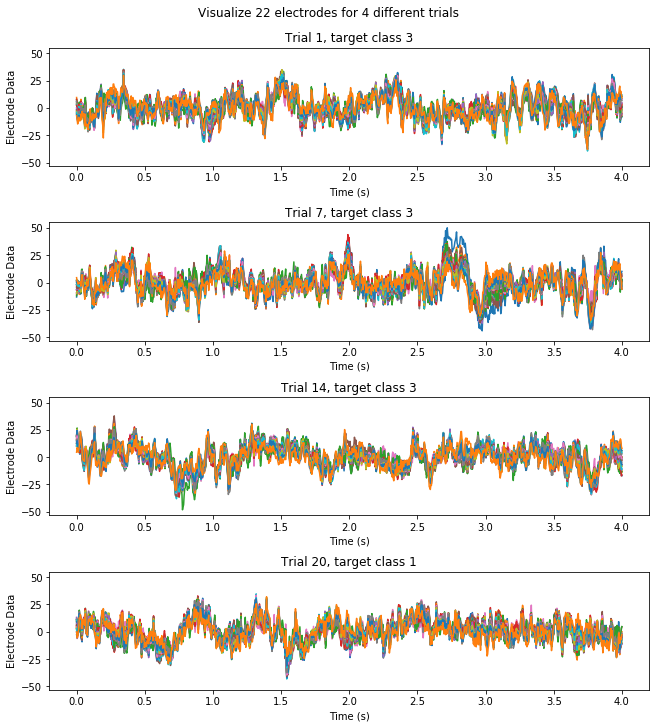

In [9]:
X_train_valid[0,:,:].shape
time = np.linspace(0, 4, num=1000)

fig, axs = plt.subplots(4,1, figsize=(9,10), sharey=True, constrained_layout=True)
for i in range(22):
  axs[0].plot(time,X_train_valid[0,i,:])
  axs[1].plot(time,X_train_valid[6,i,:])
  axs[2].plot(time,X_train_valid[13,i,:])
  axs[3].plot(time,X_train_valid[19,i,:])

fig.suptitle("Visualize 22 electrodes for 4 different trials")
axs[0].set_title("Trial 1, target class {}".format(classes[y_train_valid[0]]))
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Electrode Data')
axs[1].set_title("Trial 7, target class {}".format(classes[y_train_valid[6]]))
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Electrode Data')
axs[2].set_title("Trial 14, target class {}".format(classes[y_train_valid[13]]))
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Electrode Data')
axs[3].set_title("Trial 20, target class {}".format(classes[y_train_valid[19]]))
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Electrode Data')


### Visualize many electrodes over 1 trial

Text(0, 0.5, 'Electrode Data')

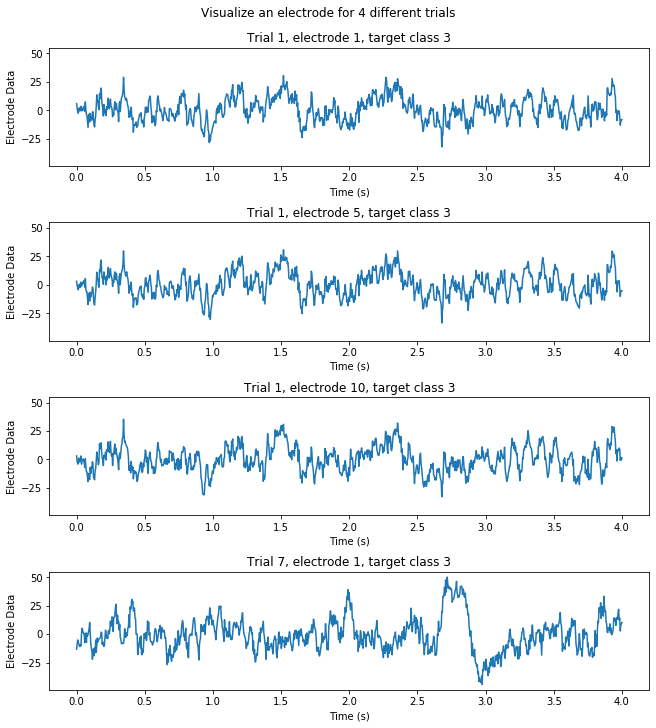

In [10]:
X_train_valid[0,:,:].shape
time = np.linspace(0, 4, num=1000)

fig, axs = plt.subplots(4,1, figsize=(9,10), sharey=True, constrained_layout=True)
#for i in range(10):
axs[0].plot(time,X_train_valid[0,0,:])
axs[1].plot(time,X_train_valid[0,4,:])
axs[2].plot(time,X_train_valid[0,9,:])
axs[3].plot(time,X_train_valid[6,0,:])

fig.suptitle("Visualize an electrode for 4 different trials")
axs[0].set_title("Trial 1, electrode 1, target class {}".format(classes[y_train_valid[0]]))
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Electrode Data')
axs[1].set_title("Trial 1, electrode 5, target class {}".format(classes[y_train_valid[0]]))
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Electrode Data')
axs[2].set_title("Trial 1, electrode 10, target class {}".format(classes[y_train_valid[0]]))
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Electrode Data')
axs[3].set_title("Trial 7, electrode 1, target class {}".format(classes[y_train_valid[6]]))
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Electrode Data')


### Visualize one electrode over multiple trials

Text(0, 0.5, 'Electrode Data')

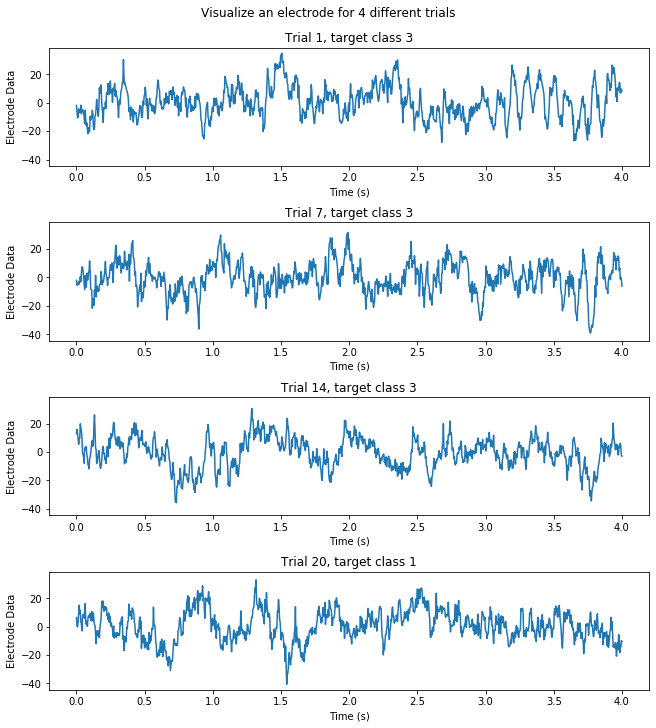

In [11]:
X_train_valid[0,:,:].shape
time = np.linspace(0, 4, num=1000)

fig, axs = plt.subplots(4,1, figsize=(9,10), sharey=True, constrained_layout=True)
#for i in range(10):
axs[0].plot(time,X_train_valid[0,15,:])
axs[1].plot(time,X_train_valid[6,15,:])
axs[2].plot(time,X_train_valid[13,15,:])
axs[3].plot(time,X_train_valid[19,15,:])

fig.suptitle("Visualize an electrode for 4 different trials")
axs[0].set_title("Trial 1, target class {}".format(classes[y_train_valid[0]]))
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Electrode Data')
axs[1].set_title("Trial 7, target class {}".format(classes[y_train_valid[6]]))
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Electrode Data')
axs[2].set_title("Trial 14, target class {}".format(classes[y_train_valid[13]]))
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Electrode Data')
axs[3].set_title("Trial 20, target class {}".format(classes[y_train_valid[19]]))
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Electrode Data')


# Define Function to Split Training Data

In [0]:
#splits the training data in half by time series
def split_even_odd(X):
  time_len = int(X.shape[-1] /2)
  even = np.arange(time_len)*2
  odd = np.arange(time_len)*2 +1
  #print(odd[(time_len-1):time_len])
  X_train_even = X[:,:,even]
  X_train_odd = X[:,:,odd]
  #print(X_train_even.shape)
  return X_train_even, X_train_odd



In [13]:
#Visualize the split data
X_train_even, X_train_odd = split_even_odd(X_train_valid)
time_len = X_train_even[0,:,:].shape
time = np.linspace(0, 4, num=time_len)

fig, axs = plt.subplots(4,1, figsize=(9,10), sharey=True, constrained_layout=True)
for i in range(22):
  axs[0].plot(time,X_train_even[0,i,:])
  axs[1].plot(time,X_train_odd[0,i,:])
axs[2].plot(time,X_train_even[0,21,:])
axs[3].plot(time,X_train_odd[0,21,:])
fig.suptitle("Visualize electrodes for same trial split into two datasets")
axs[0].set_title("Trial 1 (even), target class {}".format(classes[y_train_valid[0]]))
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Electrode Data')
axs[1].set_title("Trial 1 (odd), target class {}".format(classes[y_train_valid[0]]))
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Electrode Data')
axs[2].set_title("Trial 1 (even), electrode 22")
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Electrode Data')
axs[3].set_title("Trial 1 (odd), electrode 22")
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Electrode Data')

TypeError: ignored

# Interpolate data

In [0]:
#Change the number of time points in the data (can be used for X_train and X_test data)
def interp(X, time_len):
  old_times = np.linspace(0, 4, num=X.shape[-1])
  new_times = np.linspace(0, 4, num=time_len)
  X_new = np.empty([X.shape[0],X.shape[1],time_len])
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      X_new[i,j,:] = np.interp(new_times, old_times, X[i,j,:])
  return X_new

X_2000 = interp(X_test, 2000)
print(X_2000.shape)

# Wavelet Transform


In [0]:
pywt.cwt(X_train_valid[0,0,:], scales, wavelet)

In [0]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.show()